In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import integrate, stats
import pymc3 as pm
import corner
%matplotlib inline

## Loading the data

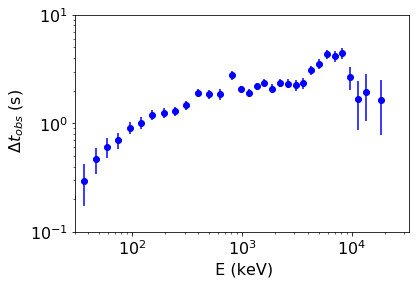

In [2]:
data = np.loadtxt("time_lag_data_plot.txt")
E = data[:,0]
t_obs = data[:,1]
err = data[:,2]
plt.xscale("log")
plt.yscale("log")
plt.xlim(30,1E5/3)
plt.ylim(0.1,10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r' E (keV)', fontsize=16)
plt.ylabel(r' $\Delta t_{obs}$ (s)', fontsize=16)
for a, b, c in zip(E, t_obs, err):
    if b>0:
        plt.errorbar(a, b, c, fmt='bo')

## The null hypothesis

Here we define the model for null hypothesis which has the free variables $\tau$ and $\alpha$. Labeling this model as $M_0$ we can say:

$$
y \sim \mathcal{N}(y_{M_0}, \sigma_y^2)
$$

After defining the model, we run the ADVI to approximate posterior for $y_{M_0}$ and draw traces of the free variables estimated by the model. The first thing to check is whether $ELBO$ has convereged or not. Then from the traces of free variables we generate values of $y_{M_0}$ by using the sample_ppc (ppc stands for *Predictive Posterior Check*) function of PYMC3 by supplying it with traces of our free variables. We then plot $y_{M_0}$ over the original data to see how well it models the data.

We repeat this for models where $n=1$ and $n=2$.

In [3]:
E_0 = 11.34
H_0 = 67.3
O_M = 0.315
O_L = 1 - O_M
z = 1.41

def t1(x,tau,a):
    return (tau*(x**a - E_0**a))
ta, covar = curve_fit(t1, E, t_obs, sigma=err)

print(ta)

with pm.Model() as model_null:
    tau = pm.Uniform('tau',lower=0,upper=1)
    alpha = pm.Uniform('alpha',lower=0,upper=1)
    mu = tau * (E**alpha - E_0**alpha)
    y_obs = pm.Normal('y_obs',mu=mu,sd=err, observed=t_obs)

[ 5.86514392  0.05860804]


In [4]:

with model_null:
    inference = pm.ADVI()
    params = pm.fit(n=100000,method=inference)
    traces = pm.sample_approx(params,draws=1000)
    ppc = pm.sample_ppc(traces)

Average Loss = 46.707: 100%|██████████| 100000/100000 [00:05<00:00, 17384.87it/s]  
Finished [100%]: Average Loss = 46.715
100%|██████████| 1000/1000 [00:01<00:00, 684.80it/s]


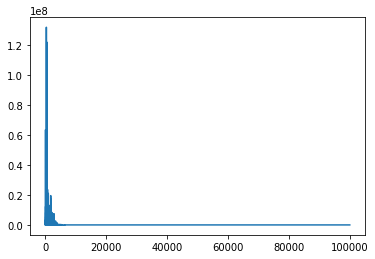

In [17]:
plt.plot(params.hist)
elbo_null = -params.hist[-1]

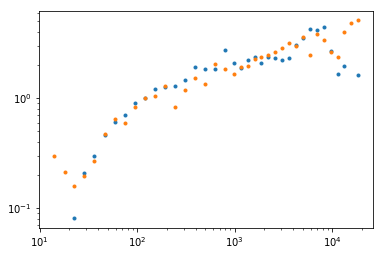

In [6]:
plt.xscale("log")
plt.yscale("log")
plt.plot(E,t_obs,'.')
plt.plot(E,ppc['y_obs'][-1],'.')

In [10]:
data1 = traces['tau']
data2 = traces['alpha']
ndim = 2
nsamples = len(data1)

#fig = corner.corner(data)

In [11]:
n = 1
def integrand(i):
    return ((1+i)**n/np.sqrt(O_M*(1+i)**3+O_L))
I1, e1 = integrate.quad(integrand, 0, z)
with pm.Model() as model_1:
    tau = pm.Uniform('tau',lower=0,upper=5)
    alpha = pm.Uniform('alpha',lower=0,upper=1)
    E_qg = pm.Uniform('E_qg',lower=0,upper=1e15)
    logEqg =  pm.Deterministic('logEqg', np.log(E_qg))
    mu = tau*(E**alpha - E_0**alpha) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**14)*I1/(E_qg**n)
    y_obs = pm.Normal('y_obs',mu=mu,sd=err, observed=t_obs)

In [12]:
with model_1:
    inference = pm.ADVI()
    params_1 = pm.fit(n=100000,method=inference)
    traces_1 = pm.sample_approx(params_1, draws=1000)
    ppc_1 = pm.sample_ppc(traces_1)

Average Loss = 64.712: 100%|██████████| 100000/100000 [00:06<00:00, 14410.47it/s]  
Finished [100%]: Average Loss = 64.695
100%|██████████| 1000/1000 [00:00<00:00, 1249.44it/s]


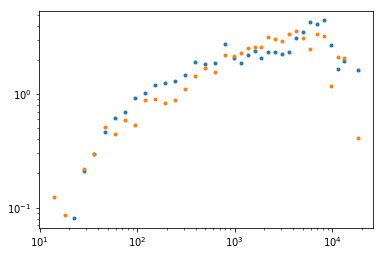

In [13]:
plt.xscale("log")
plt.yscale("log")
plt.plot(E,t_obs,'.')
plt.plot(E,ppc_1['y_obs'][-1],'.')


-63.575136646487195

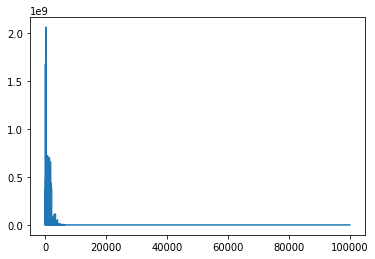

In [16]:
plt.plot(params_1.hist)
elbo_1 = -params_1.hist[-1]
elbo_1

In [18]:
n = 2
def integrand(i):
    return ((1+i)**n/np.sqrt(O_M*(1+i)**3+O_L))
I2, e2 = integrate.quad(integrand, 0, z)
with pm.Model() as model_2:
    tau = pm.Uniform('tau',lower=1,upper=5)
    alpha = pm.Uniform('alpha',lower=0,upper=0.19)
    E_qg = pm.Uniform('E_qg',lower=0,upper=1e7)
    Eqg_log = pm.Deterministic('logEqg', np.log(E_qg))
    mu = tau*(E**alpha - E_0**alpha) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**8)*I2/(E_qg**n)
    y_obs = pm.Normal('y_obs',mu=mu,sd=err, observed=t_obs)

In [19]:
with model_2:
    inference = pm.ADVI()
    params_2 = pm.fit(n=100000,method=inference)
    traces_2 = pm.sample_approx(params_2,draws=1000)
    ppc_2 = pm.sample_ppc(traces_2)

Average Loss = 41.459: 100%|██████████| 100000/100000 [00:07<00:00, 13834.22it/s]
Finished [100%]: Average Loss = 41.463
100%|██████████| 1000/1000 [00:02<00:00, 337.87it/s]


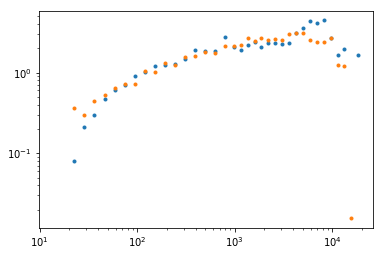

In [20]:
plt.xscale("log")
plt.yscale("log")
plt.plot(E,t_obs,'.')
plt.plot(E,ppc_2['y_obs'][-1],'.')

-41.275872490163025

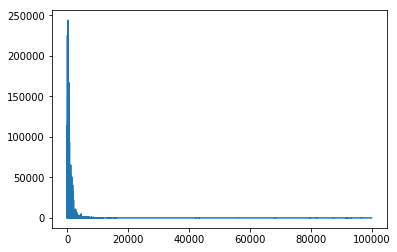

In [21]:
plt.plot(params_2.hist)
elbo_2 = -params_2.hist[-1]
elbo_2

Now we have all three models we can do model selection. Here we investigate two ways of  model selection : $WAIC$ and $Bayes Factor$.
We use the PYMC3's *compare* functioin to get WAIC for the three models and it supports model with n=2. Next we calculate the Bayes Factor. We find the *Odd's ratio* as:

$$
O_{21} \equiv \frac{P(M_2~|~D)}{P(M_1~|~D)} = \frac{P(D~|~M_2)}{P(D~|~M_1)}\frac{P(M_2)}{P(M_1)}
$$

Here the ratio $P(M_2) / P(M_1)$ is the *prior odds ratio*, and is often assumed to be equal to 1 if no compelling prior evidence favors one model over another.
The ratio $P(D~|~M_2) / P(D~|~M_1)$ is the *Bayes factor*, and is the key to Bayesian model selection.

The Bayes factor can be computed by evaluating the integral over the parameter likelihood:

$$
P(D~|~M) = \int_\Omega P(D~|~\theta, M) P(\theta~|~M) d\theta
$$

This integral is over the entire parameter space of the model, and thus can be extremely computationally intensive, especially as the dimension of the model grows beyond a few.

However, PYMC3 supplies us with log joint likelihood of the model as *logp* function. So we can approximate $P(D~|~M)$ as the mean of exponentiation of this joint likelihood:

$$
P(D~|~M) = 1/n\sum_{i=1}^n P(D~|~\theta_i, M) P(\theta_i~|~M) 
$$

In [22]:
pm.stats.compare((traces,traces_1,traces_2),(model_null,model_1,model_2))


,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
2,76.92,10.79,0,0.55,34.14,0,1
0,86.22,7.02,9.3,0.45,31.88,31.34,1
1,125.12,20,48.2,0,31.07,19.05,1


In [23]:
z0 = np.exp(np.array([model_null.logp(pt) for pt in traces])).mean()
z1 = np.exp(np.array([model_1.logp(pt) for pt in traces_1])).mean() 
z2 = np.exp(np.array([model_2.logp(pt) for pt in traces_2])).mean()
bf01 = z2/z1
bf02 = z2/z0
print(z0,z1,z2)
print('bayes factor (n=2/n=1):' + str(bf01))
print('bayes factor (n=2/null):' + str(bf02))

5.95759022089e-20 3.78436821561e-26 1.13478805237e-17
bayes factor (n=2/n=1):299861955.212
bayes factor (n=2/null):190.47769489


# Parameters for n = 1

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea7910a8d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fea6a137048>], dtype=object)

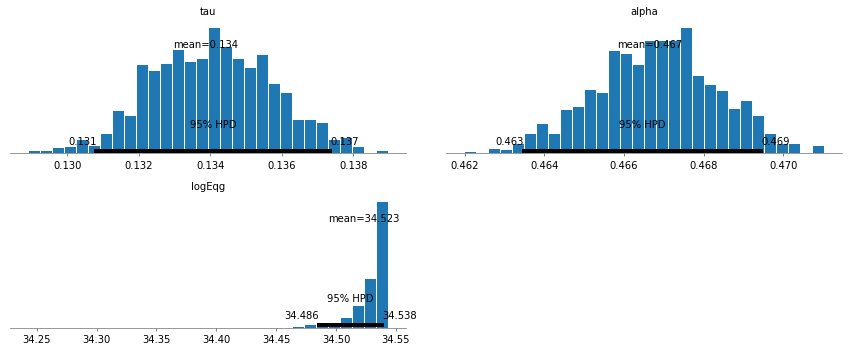

In [24]:
pm.plot_posterior(traces_1,varnames=['tau','alpha','logEqg'])

# Parameters for n = 2

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea722f89e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fea722f4358>], dtype=object)

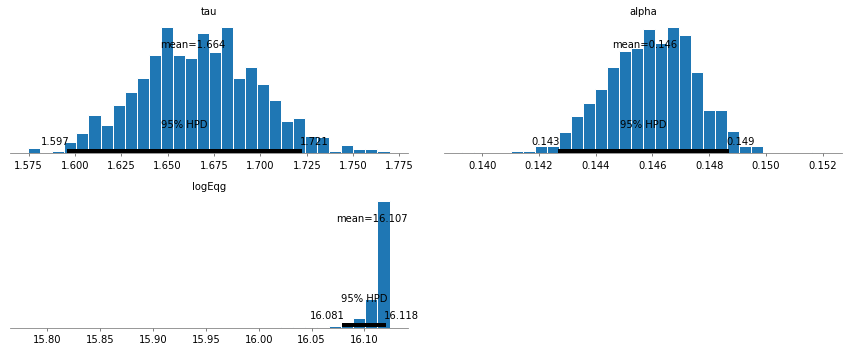

In [25]:
pm.plot_posterior(traces_2,varnames=['tau','alpha','logEqg'])

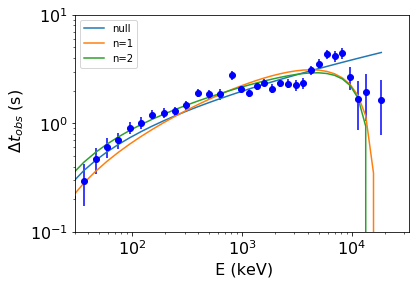

In [26]:
plt.xscale("log")
plt.yscale("log")
plt.xlim(30,1E5/3)
plt.ylim(0.1,10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r' E (keV)', fontsize=16)
plt.ylabel(r' $\Delta t_{obs}$ (s)', fontsize=16)
for a, b, c in zip(E, t_obs, err):
    if b>0:
        plt.errorbar(a, b, c, fmt='bo')
tau_null = traces['tau'].mean()
alpha_null = traces['alpha'].mean()
plt.plot(E,tau_null * (E**alpha_null - E_0**alpha_null),label='null')
tau_1 = traces_1['tau'].mean()
alpha_1 = traces_1['alpha'].mean()
Eqg_1 = traces_1['E_qg'].mean()
n=1
tob_1 = tau_1*(E**alpha_1 - E_0**alpha_1) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**14)*I1/(Eqg_1**n)
plt.plot(E,tob_1,label='n=1')
n=2
tau_2 = traces_2['tau'].mean()
alpha_2 = traces_2['alpha'].mean()
Eqg_2 = traces_2['E_qg'].mean()
tob_2 = tau_2*(E**alpha_2 - E_0**alpha_2) + (-(1+n)/(2*H_0*3.24))*(E**n-E_0**n)*(10**8)*I2/(Eqg_2**n)
plt.plot(E,tob_2,label='n=2')
plt.legend()

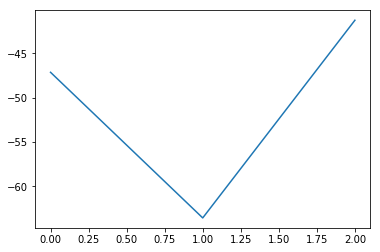

In [27]:
elbo_val = [elbo_null, elbo_1, elbo_2]
plt.plot(elbo_val)